In [1]:
import keras
import numpy as np
from neuralStellar import *
import pymc3 as pm
import theano.tensor as T

Using TensorFlow backend.


In [10]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
#m1.loadModel('SGM_lrtest.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

In [11]:
Msun=1
Agesun=4.5
Fehsun=0
MLTsun=1.9
print('L/Lsun', 'Teff', 'delta nu', '=')
print(10**m1.model.predict(np.array([[np.log10(Msun),np.log10(Agesun),Fehsun,MLTsun]])).T)
#1, 5777, 135

L/Lsun Teff delta nu =
[[1.0957384e+00]
 [5.9089731e+03]
 [1.3488092e+02]]


Inputs:
M=N(1,0.1)<br>
Age=N(4.5,0.5)<br>
feh=N(0,0.1)<br>
MLT=N(1.9,0.1)<br>
<br>
Outputs(obs):<br>
L=N(1,0.1)<br>
Teff=N(5777,70)<br>
delnu=N(135,15)<br>

In [16]:
weights=m1.model.get_weights()

def NN(inputs):
    #input shape = 1D array with length as number of NN inputs
    no_hidden_layers=len(weights)/2-1
    xx=inputs
    for i in np.arange(0,no_hidden_layers)*2:
        i=int(i)
        xx=T.nnet.relu(pm.math.dot(xx,weights[i])+weights[i+1],0)
    xx=pm.math.dot(xx,weights[-2])+weights[-1]
    return xx.T

model = pm.Model()
with model:
    
    log_m = pm.Normal('log_mass',np.log10(1),0.1)
    log_a = pm.Normal('log_age',np.log10(4.5),0.1)
    feh = pm.Normal('feh',0,0.1)
    MLT = pm.Normal('MLT',1.9,0.1)
    
    obs = pm.Deterministic('obs',NN([log_m, log_a, feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0],0.1, observed=1.0)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1],70, observed=5777)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],15, observed=135)

with model:
    trace = pm.sample(tune=5000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [MLT, feh, log_age, log_mass]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 11000/11000 [04:10<00:00, 43.83draws/s]


In [17]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_mass,-0.011051,0.013600,0.000622,-0.034827,0.016995,365.779076,1.003841
log_age,0.676606,0.100363,0.004116,0.482519,0.872005,517.111206,1.001599
feh,-0.000657,0.103587,0.003806,-0.190680,0.195292,606.709743,0.999035
MLT,1.911915,0.096927,0.004136,1.721679,2.088407,425.074509,1.000382
obs__0,-0.020899,0.034917,0.001085,-0.088361,0.046403,978.143560,1.001077
obs__1,3.765499,0.003431,0.000115,3.759311,3.772373,858.081432,1.001118
obs__2,2.150393,0.016165,0.000511,2.118067,2.180764,883.297111,0.999812


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A245E5EB8>,
      dtype=object)

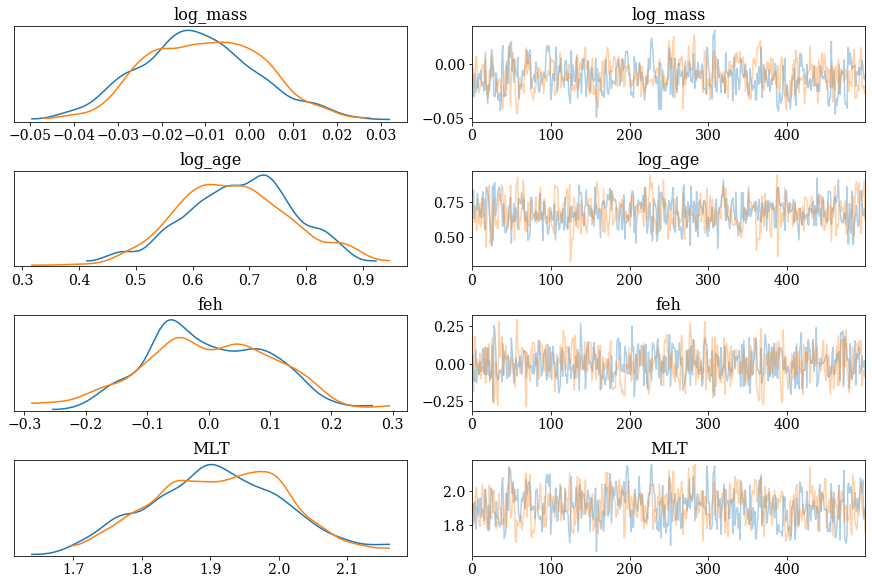

In [18]:
pm.plots.traceplot(trace,var_names=['log_mass','log_age','feh','MLT'])

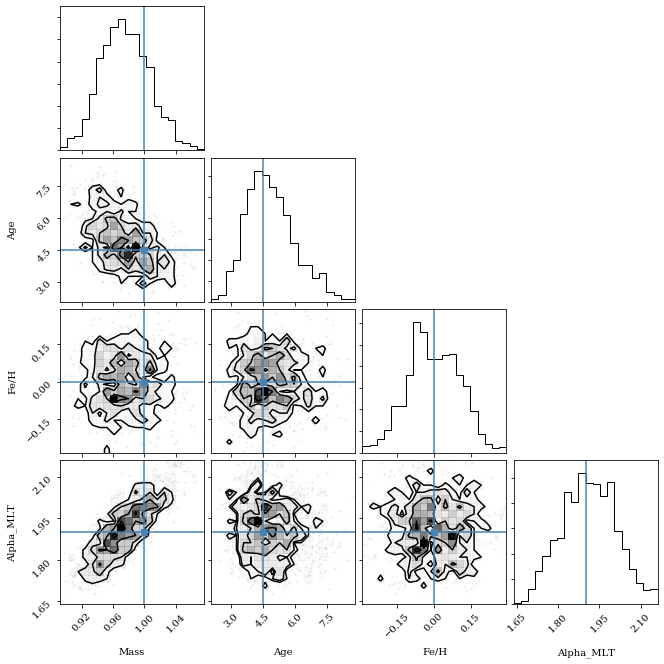

In [20]:
import corner
corner.corner(np.array([10**trace['log_mass'], 10**trace['log_age'], trace['feh'], trace['MLT']]).T, truths=[1.0, 4.5, 0, 1.9],
             labels=['Mass', 'Age', 'Fe/H', 'Alpha_MLT']);